In [324]:
%%javascript

IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [325]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import ascii
import json
from IPython.display import display, Image
from specutils import Spectrum1D
from astropy import units
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from astropy.time import Time

In [326]:
#Define function to get relevant spectra from OSN JSON data file
def Grab_Spec_of_interest(JSON, MJD_max, phase):
    #Load OSN json data
    file = open('../Data/OSN_data/' + str(JSON))
    json_data = json.load(file)
    Spectra = json_data[JSON[0:-5]]['spectra']
    Spectra = np.array(Spectra)
    #initialize empty array to hold the epochs for various spectra
    epochs = []
    
    #populate time array
    for i in range(len(Spectra)):
        epochs.append(float(Spectra[i]['time']))
    #calculate times relative to maximum brightness
    times_rel_max= np.array([x - MJD_max for x in epochs])
    
    #Grab indices for times of interest (within 4 days of time rel to max brightness for spectra of interest)
    times_interest = np.where((times_rel_max < phase + 4) & (times_rel_max > phase - 4))
    #Filter for spectra of interets
    
    #relevant phase
    Spectra_interest = Spectra[times_interest]
    return Spectra_interest

def convert_date_toMJD(date):
    '''
    date - string of calendar date (e.g. '2002-8-17')
    '''
    t = Time(date)
    t.format = 'mjd'
    return t.value
    

#Define function that corrects fluxes for redshift
def correct_flux(flux_obs, z):
    flux_emit = (z * flux_obs) + flux_obs
    return flux_emit

#Define function to calculate absorption velocities
def calc_abs_velc(restframe, dopplershifted):
    velocity = ((restframe - dopplershifted) / np.float(restframe))* c
    return velocity


#define function that converts wavlengths to restframe and corrects flux for redshift, and normalizes flux
def Unpack_Spectra(Spectra, z, normalization = [5000,5200]):
    '''
    Spectra - one epoch of spectral data in JSON format from OSN
    z - redshift of SN
    index - 
    
    Flux is corrected for redshift and normalized
    
    Wavelength is converted to SN restframe
    
    returns pandas dataframe with 2 columns: wavelength and flux
    
    '''
    #Extract Wavelengths 
    wavelengths = [float(x[0]) for x in Spectra]
    
    #Extract Fluxes 
    fluxes = [float(x[1]) for x in Spectra]
    
    #correct fluxes for redshift
    fluxes = [correct_flux(flux, z) for flux in fluxes]
    
    #Extract fluxes in normalization range
    rel_flux_range = [x for x in Spectra if (float(x[0])>normalization[0]) & (float(x[0])<normalization[1])]
    
    #Make sure there rel_flux_range isnt empty
    if len(rel_flux_range) == 0:
        print('No wavelengths in normalization region')
        return None
    
    #Calculate average flux in this range
    flux_sum = 0
    for x in rel_flux_range:
        flux_sum += float(x[1])
    average_flux = flux_sum / float(len(rel_flux_range))
    
    #Normalize flux
    fluxes = [float(flux) / average_flux for flux in fluxes]
    
    #convert wavelength to restframe
    wavelengths = [wavelength / float(1 + z) for wavelength in wavelengths]
    
    #store in pandas dataframe
    df = pd.DataFrame()
    df['Flux'] = fluxes
    df['Wavelength'] =  wavelengths
    return df


In [327]:
class Spectra:
    
    #initialization
    def __init__(self, Spectra, z, MJD_max, epoch, SN):
        
        '''
        Spectra - JSON formatted spectra file
        z - redshift of assoicated SN
        SN - string of supernovae name
        MJD_max - MJD date of B band maximum
        epoch - epoch in MJD of observation
        
        '''
        self.SN = SN
        self.spectra = Unpack_Spectra(Spectra, z)
        self.z = z
        self.epoch = float(epoch)
        self.phase = float(epoch) - MJD_max

# iPTF16hvw Spectral Analysis


In [328]:
#Read In spectral data

#11/07/2016
spectrum1 = ascii.read('../Data/16hvw_spectra/16hvw_20161107_Gemini_N_v4.ascii')

#11/09/2016
spectrum2 = ascii.read('../Data/16hvw_spectra/16hvw_20161109_P60_v1.ascii')

#11/28/2016
spectrum3 = ascii.read('../Data/16hvw_spectra/16hvw_20161128_NOT_v1.ascii')

#12/06/2016
spectrum4 = ascii.read('../Data/16hvw_spectra/16hvw_20161206_NOT_v1.ascii')


#redshift of SN iPTF 16hvw
z_16hvw = .03663

#MJD date for maximum brightness iPTF16hvw
MJD_max_16hvw = 57714.40
type(spectrum1)

astropy.table.table.Table

In [329]:
#Convert wavelength to resframe, correct flux for redshif, normalize flux 
Spec_16hvw1 = Spectra(spectrum1, z_16hvw, MJD_max_16hvw,  convert_date_toMJD('2016-11-7'), "iPTF16hvw")
Spec_16hvw2 = Spectra(spectrum2, z_16hvw, MJD_max_16hvw,  convert_date_toMJD('2016-11-9'), "iPTF16hvw")
Spec_16hvw3 = Spectra(spectrum3, z_16hvw, MJD_max_16hvw,  convert_date_toMJD('2016-11-28'), "iPTF16hvw")
Spec_16hvw4 = Spectra(spectrum4, z_16hvw, MJD_max_16hvw,  convert_date_toMJD('2016-12-6'), "iPTF16hvw")

### Plotting Spectra 


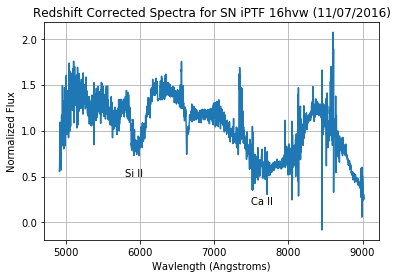

In [330]:
#Create plot of 16hvw spectra (-16.5 days)
plt.plot(Spec_16hvw1.spectra['Wavelength'], Spec_16hvw1.spectra['Flux'])
plt.xlabel('Wavlength (Angstroms)')
plt.title('Redshift Corrected Spectra for SN iPTF 16hvw (11/07/2016)')
plt.ylabel('Normalized Flux')
plt.grid()

#Add text indicating Absorption lines
plt.text(5800, .5, "Si II")
plt.text(7500,.20, "Ca II")


#Save and show figure
plt.savefig('../Images/16hvw_Spectra_plots/16hvw_20161107_spectra')
plt.show()


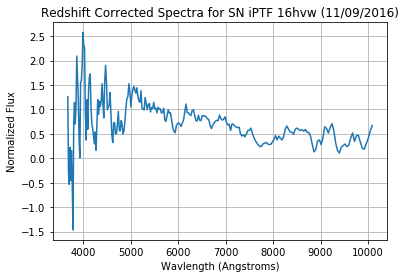

In [331]:
#Create plot of 16hvw spectra (-14.5 days)
plt.plot(Spec_16hvw2.spectra['Wavelength'], Spec_16hvw2.spectra['Flux'])
plt.xlabel('Wavlength (Angstroms)')
plt.title('Redshift Corrected Spectra for SN iPTF 16hvw (11/09/2016)')
plt.ylabel('Normalized Flux')

plt.grid()

#Add text indicating Absorption lines

'''
plt.text(6000, 0e-16, "Si II")
plt.text(7900, -.2e-16, "Ca II")
plt.text(4700,-.1e-16,"Fe II")
plt.text(5600, 3e-16,"S II")
plt.text(3800, -1.9e-16, "Ca II")
plt.text(4200, 2.1e-16, "Fe II")
'''

#Save and show figure
plt.savefig('../Images/16hvw_Spectra_plots/16hvw_20161109_spectra')
plt.show()


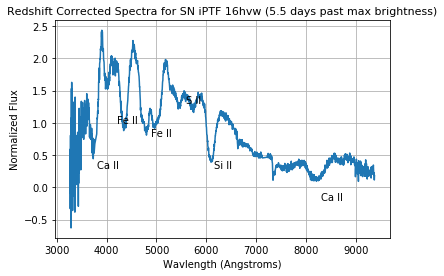

In [332]:
#Create plot of 16hvw spectra (+5.5 days)
plt.plot(Spec_16hvw3.spectra['Wavelength'], Spec_16hvw3.spectra['Flux'])
plt.xlabel('Wavlength (Angstroms)')
plt.title('Redshift Corrected Spectra for SN iPTF 16hvw (5.5 days past max brightness)', fontsize=11)
plt.ylabel('Normalized Flux')

plt.grid()

#Add text indicating Absorption lines
plt.text(6150, .3, "Si II")
plt.text(8300, -0.2, "Ca II")
plt.text(4900, .8,"Fe II")
plt.text(5600, 1.3,"S II")
plt.text(3800, .3, "Ca II")
plt.text(4200, 1, "Fe II")

#Save and show figure
plt.savefig('../Images/16hvw_Spectra_plots/16hvw_20161128_spectra')
plt.show()

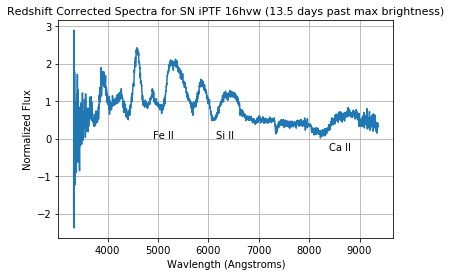

In [333]:
#Create plot of 16hvw spectra (+13.5 days)
plt.plot(Spec_16hvw4.spectra['Wavelength'], Spec_16hvw4.spectra['Flux'])
plt.xlabel('Wavlength (Angstroms)')
plt.title('Redshift Corrected Spectra for SN iPTF 16hvw (13.5 days past max brightness)', fontsize=11)
plt.ylabel('Normalized Flux')


plt.grid()

#Add text indicating Absorption lines
plt.text(6150, .2e-16, "Si II")
plt.text(8400, -.3, "Ca II")
plt.text(4900, .6e-16,"Fe II")
#plt.text(5600, 3e-16,"S II")
#plt.text(3800, .8e-16, "Ca II")
#plt.text(4200, 2.1e-16, "Fe II")

#Save and show figure
plt.savefig('../Images/16hvw_Spectra_plots/16hvw_20161206_spectra')
plt.show()

### Estimate Absorption Velocities



In [334]:
#Estimate absorption velocities 


#store restframe wavelengths of absorption in Angstroms
SiII_restframe = 6355

#Ca II is a triplet - used the average wavelength 
CaII_restframe = (8498 + 8542 + 8662) / float(3)

#speed of light (km/s)
c = 3e5 

#store absorption minimum wavelength for Si II, Ca II lines; estimated minimum from pandas dataframe
#Divided by 1+z to convert doppler shifted wavelengths to the SN restframe 


SiII_absorption_minimum_1 = 6203 / (1 + z_16hvw)
CaII_absorption_minimum_1 = 7996 / (1 + z_16hvw)


SiII_absorption_minimum_2 = 6152 / (1 + z_16hvw)
CaII_absorption_minimum_2 = 8004 / (1 + z_16hvw)


SiII_absorption_minimum_3 = 6317 / (1 + z_16hvw)
CaII_absorption_minimum_3 = 8505 / (1 + z_16hvw)


SiII_absorption_minimum_4 = 6322 / (1 + z_16hvw)
CaII_absorption_minimum_4 = 8561 / (1 + z_16hvw)

In [335]:
#Calculate SiII absorption velocities (km/s)
print(calc_abs_velc(SiII_restframe, SiII_absorption_minimum_1))
print(calc_abs_velc(SiII_restframe, SiII_absorption_minimum_2))
print(calc_abs_velc(SiII_restframe, SiII_absorption_minimum_3))
print(calc_abs_velc(SiII_restframe, SiII_absorption_minimum_4))

17522.599577173427
19845.08021905059
12331.17226003619
12103.478079459965


In [336]:
#Calculate CaII absorption velocities (km/s)
print(calc_abs_velc(CaII_restframe, CaII_absorption_minimum_1))
print(calc_abs_velc(CaII_restframe, CaII_absorption_minimum_2))
print(calc_abs_velc(CaII_restframe, CaII_absorption_minimum_3))
print(calc_abs_velc(CaII_restframe, CaII_absorption_minimum_4))

29899.98861356777
29629.75348461687
12706.2785340663
10814.632631409906


# SN2011fe Spectral Analysis

In [337]:
#MJD date for maximum brightness SN2011fe
MJD_max_2011fe = 55814

#MJD date for iPTF16hvw spectra of interest
#11/28/16
date1 = 57720

#12/06/16
date2 = 57728

#Redshift of 2011fe gathered from OSN
z_2011fe = 0.000804

#MJD days past maximum 

#phase of iPTF16hvw 11/28/16 spectra
dpm1 = date1 - MJD_max_16hvw

#phase of iPTF16hvw 12/06/16 spectra
dpm2 = date2 - MJD_max_16hvw

In [338]:
#Grab 2011fe spectra with phases near 5.6 days past maximum
Spec_2011fe = Grab_Spec_of_interest('SN2011fe.json', MJD_max_2011fe, 5.6)

#Grab 2011fe spectra with phases near 13.6 and append
Spec_2011fe = np.append(Spec_2011fe, Grab_Spec_of_interest('SN2011fe.json', MJD_max_2011fe, 13.6))


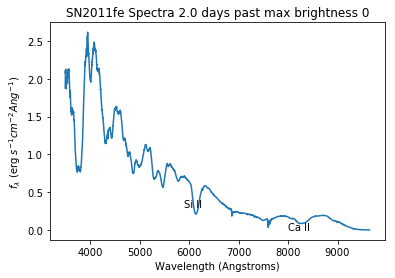

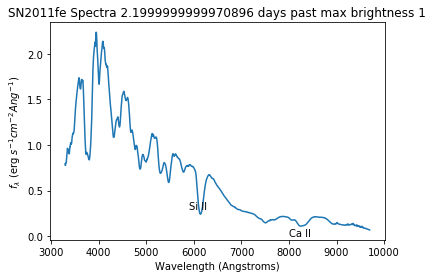

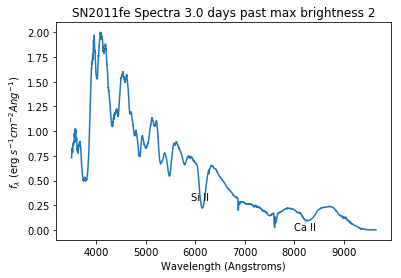

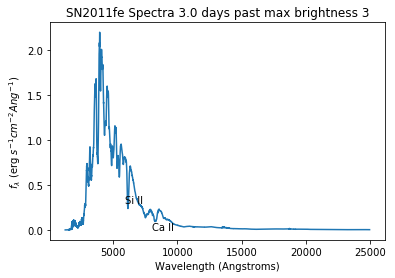

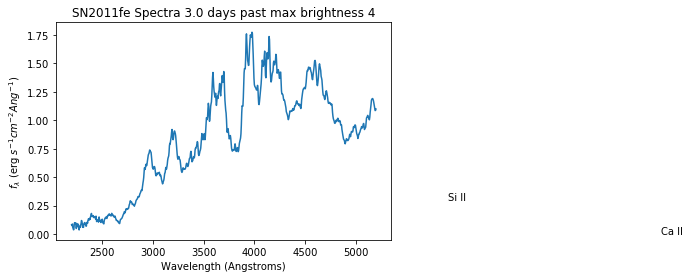

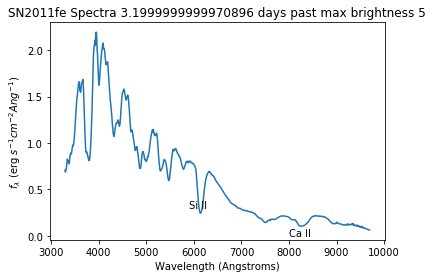

No wavelengths in normalization region
No wavelengths in normalization region
No wavelengths in normalization region
No wavelengths in normalization region
No wavelengths in normalization region
No wavelengths in normalization region
No wavelengths in normalization region
No wavelengths in normalization region
No wavelengths in normalization region


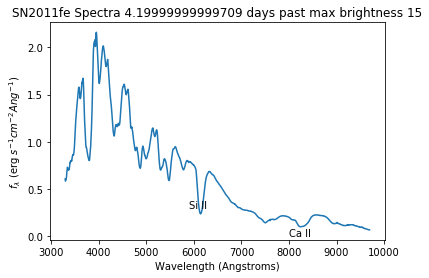

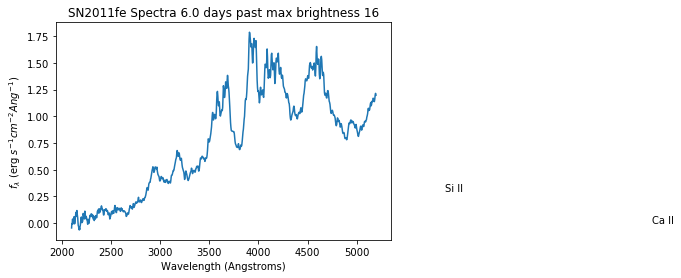

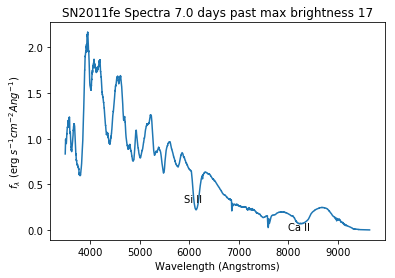

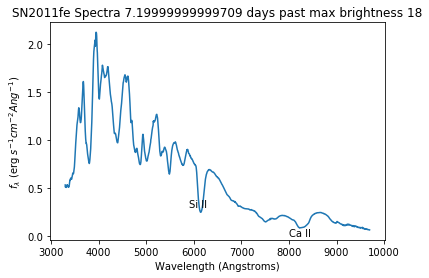

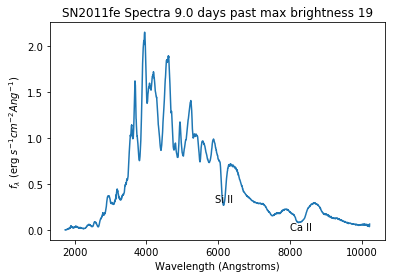

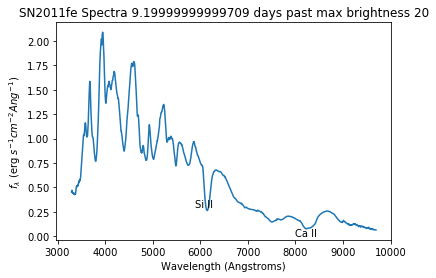

No wavelengths in normalization region
No wavelengths in normalization region
No wavelengths in normalization region
No wavelengths in normalization region
No wavelengths in normalization region
No wavelengths in normalization region
No wavelengths in normalization region


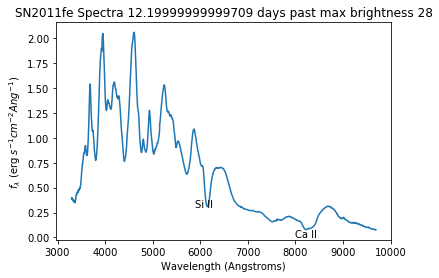

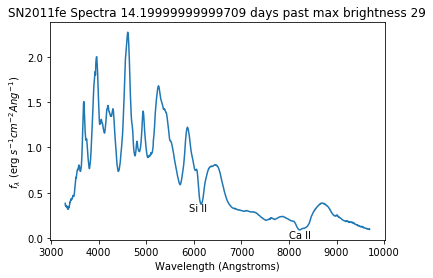

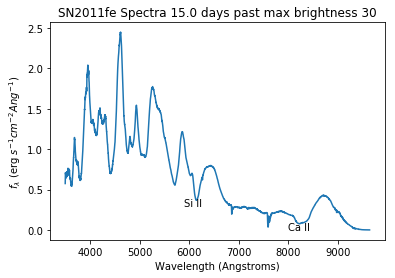

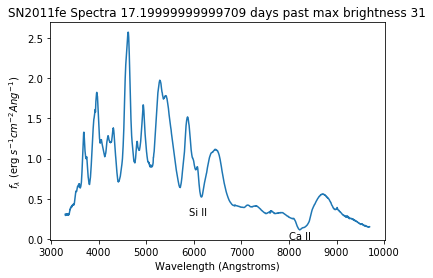

In [339]:
#Run loop to look at 2011fe spectra 
for i in range(len(Spec_2011fe)):
    
    df = Unpack_Spectra(Spec_2011fe[i]['data'], z_2011fe)
    
    #Continue if spectra has no wavelengths in normalization region
    if(df is None):
        continue
    
    
    #Plot the spectra
    plt.plot(df['Wavelength'], df['Flux'])
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('$f_\lambda$ (erg $s^{-1} cm^{-2} Ang^{-1}$)')
    plt.text(5900, .3, "Si II")
    plt.text(8000, 0, "Ca II")
    
    #Calculate time rel to maxiumum brightness
    time_past_max = float(Spec_2011fe[i]['time']) - float(MJD_max_2011fe)
    plt.title('SN2011fe Spectra ' + str(time_past_max) + ' days past max brightness ' + str(i))
    time = str(time_past_max)
    
    plt.savefig('../Images/SN2011fe_Spectra_plots/SN2011fe_Spectra_' + time +'.jpeg')
    plt.show()

In [340]:
#Create 2011fe comparison spectral objects 
Comp_2011fe1 = Spectra(Spec_2011fe[15]['data'], z_2011fe, MJD_max_2011fe, Spec_2011fe[15]['time'], "SN2011fe")
Comp_2011fe2 = Spectra(Spec_2011fe[29]['data'], z_2011fe, MJD_max_2011fe, Spec_2011fe[29]['time'], "SN2011fe")

# Comparing iPTF16hvw and SN2011fe

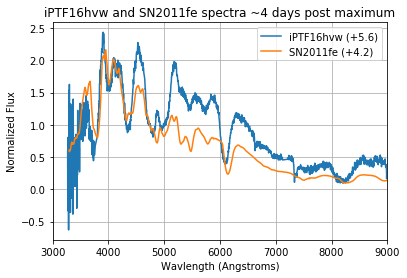

In [341]:
#Plot iPTF16hvw spectra
plt.plot(Spec_16hvw3.spectra['Wavelength'], Spec_16hvw3.spectra['Flux'], label='iPTF16hvw (+5.6)')
plt.xlabel('Wavlength (Angstroms)')
plt.title('iPTF16hvw and SN2011fe spectra ~4 days post maximum')
plt.ylabel('Normalized Flux')
plt.xlim([3000, 9000])

#plot SN2011fe spectra 
plt.plot(Comp_2011fe1.spectra['Wavelength'], Comp_2011fe1.spectra['Flux'], label='SN2011fe (+4.2)')
plt.legend()
plt.savefig('../Images/2011fe_vs_16hvw//2011fe_comparison_spectra_4days')
plt.grid()

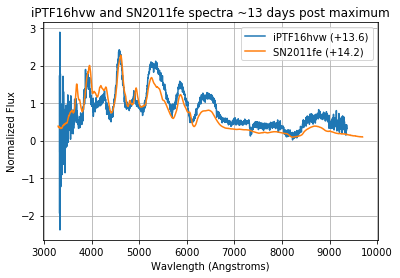

In [342]:
#Plot iPTF16hvw spectra
plt.plot(Spec_16hvw4.spectra['Wavelength'] ,Spec_16hvw4.spectra['Flux'], label='iPTF16hvw (+13.6)')
plt.xlabel('Wavlength (Angstroms)')
plt.title('iPTF16hvw and SN2011fe spectra ~13 days post maximum')
plt.ylabel('Normalized Flux')


#plot SN2011fe spectra 
plt.plot(Comp_2011fe2.spectra['Wavelength'], Comp_2011fe2.spectra['Flux'], label='SN2011fe (+14.2)')
plt.legend()
plt.savefig('../Images/2011fe_vs_16hvw//2011fe_comparison_spectra_12days')
plt.grid()


#  SN2002dj Spectral Analysis

In [349]:
#Store 2002dj B band maximum date
MJD_max_2002dj = 52450

#store 2002dj redshift
z_2002dj = 0.009393



In [350]:
#Grab 2002dj spectra with phases near 5.6 days past maximum
Spec_2002dj = Grab_Spec_of_interest('SN2002dj.json', MJD_max_2002dj, 5.6)

#Grab 2011fe spectra with phases near 13.6 and append
Spec_2002dj = np.append(Spec_2002dj, Grab_Spec_of_interest('SN2002dj.json', MJD_max_2002dj, 13.6))


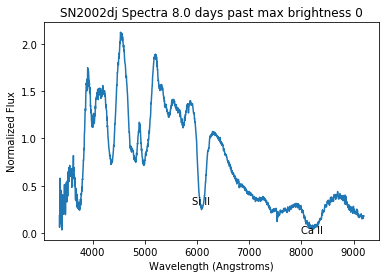

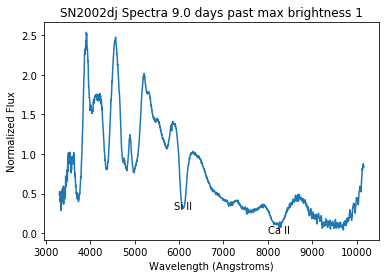

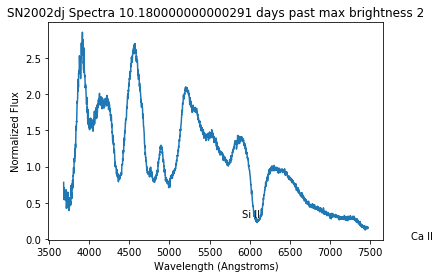

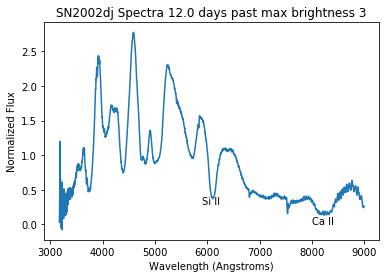

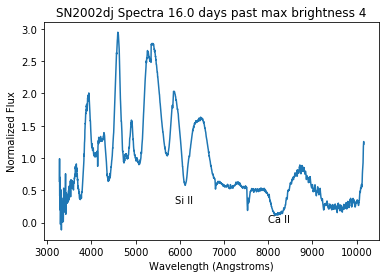

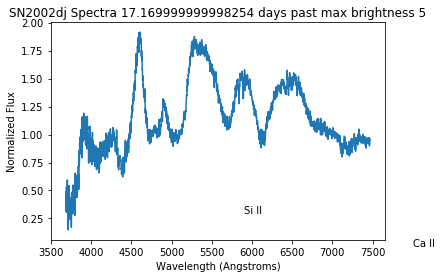

In [351]:
#Run loop to look at SN2002dj spectra of interest
for i in range(len(Spec_2002dj)):
    
    df = Unpack_Spectra(Spec_2002dj[i]['data'], z_2002dj)
    
    #Plot the spectra
    plt.plot(df['Wavelength'], df['Flux'])
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Normalized Flux')
    plt.text(5900, .3, "Si II")
    plt.text(8000, 0, "Ca II")
    
    #Calculate time rel to maxiumum brightness
    time_past_max = float(Spec_2002dj[i]['time']) - float(MJD_max_2002dj)
    plt.title('SN2002dj Spectra ' + str(time_past_max) + ' days past max brightness ' + str(i))
    time = str(time_past_max)
    
    plt.savefig('../Images/SN2002dj_Spectra_plots/SN2002dj_Spectra_' + time +'.jpeg')
    plt.show()
    

In [352]:
#Create 2002dj comparison spectral objects 
Comp_2002dj1 = Spectra(Spec_2002dj[0]['data'], z_2002dj, MJD_max_2002dj, Spec_2002dj[0]['time'], "SN2002dj")
Comp_2002dj2 = Spectra(Spec_2002dj[3]['data'], z_2002dj, MJD_max_2002dj, Spec_2002dj[3]['time'], "SN2002dj")

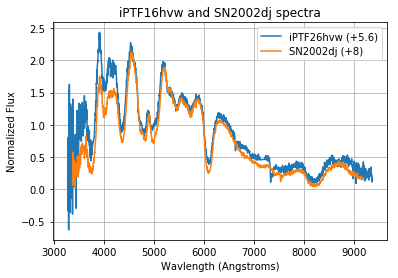

In [353]:
#Plot iPTF16hvw spectra
plt.figure()
plt.plot(Spec_16hvw3.spectra['Wavelength'], Spec_16hvw3.spectra['Flux'], label='iPTF26hvw (+5.6)')
plt.xlabel('Wavlength (Angstroms)')
plt.title('iPTF16hvw and SN2002dj spectra')
plt.ylabel('Normalized Flux')


#plot SN2002dj spectra 
plt.plot(Comp_2002dj1.spectra['Wavelength'], Comp_2002dj1.spectra['Flux'], label='SN2002dj (+8)')
plt.legend()
plt.savefig('../Images/2002dj_vs_16hvw/2002dj_comparison_spectra_8days')
plt.grid()

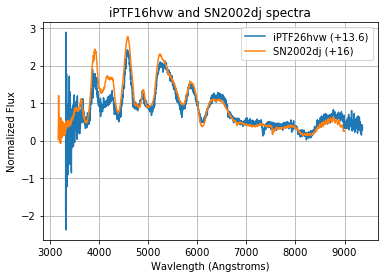

In [354]:
#Plot iPTF16hvw spectra
plt.figure()
plt.plot(Spec_16hvw4.spectra['Wavelength'], Spec_16hvw4.spectra['Flux'], label='iPTF26hvw (+13.6)')
plt.xlabel('Wavlength (Angstroms)')
plt.title('iPTF16hvw and SN2002dj spectra')
plt.ylabel('Normalized Flux')


#plot SN2002dj spectra 

plt.plot(Comp_2002dj2.spectra['Wavelength'], Comp_2002dj2.spectra['Flux'], label='SN2002dj (+16)')
plt.legend()
plt.savefig('../Images/2002dj_vs_16hvw/2002dj_comparison_spectra_16days')
plt.grid()

# SN2002bo Spectral Analysis


In [355]:
#Store date of B bandmax brightness SN2002ob
MJD_max_2002bo = 52356  

#Store redshift of SN2002bo
z_2002bo = .0044

In [356]:
#Grab 2002bo spectra with phases near 5.6 days past maximum
Spec_2002bo = Grab_Spec_of_interest('SN2002bo.json', MJD_max_2002bo, 5.6 )

#Grab 2002bo spectra with phases near 13.6 and append
Spec_2002bo = np.append(Spec_2002bo, Grab_Spec_of_interest('SN2002bo.json', MJD_max_2002bo, 13))


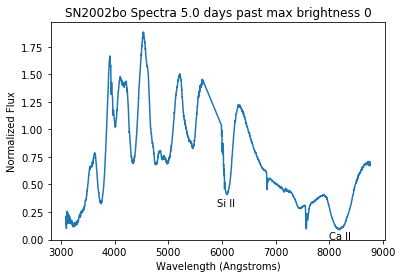

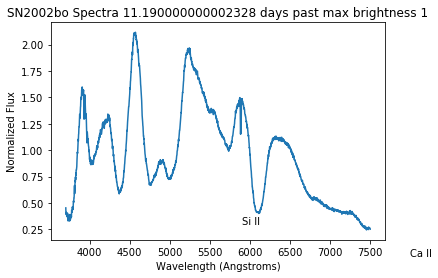

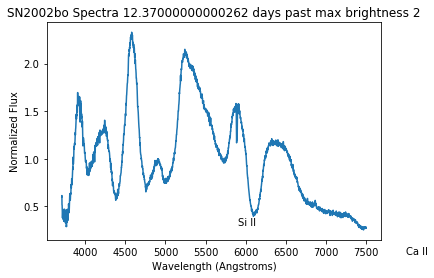

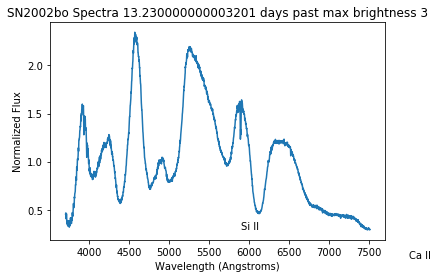

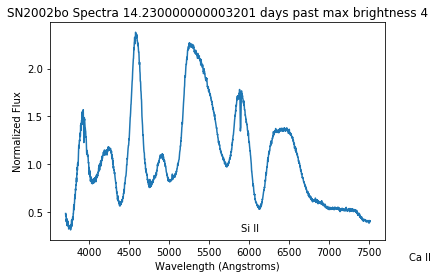

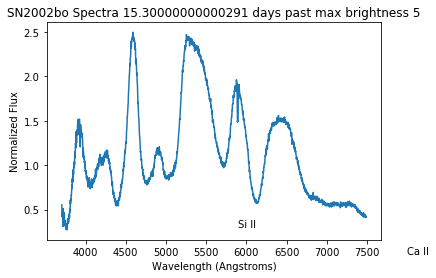

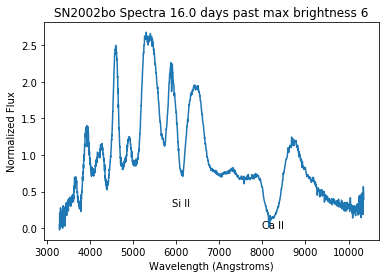

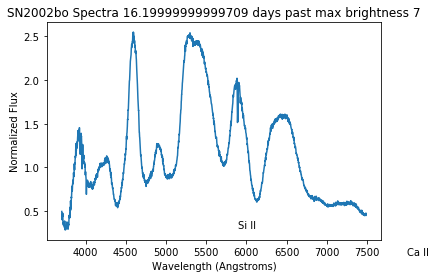

In [357]:
#Run loop to look at SN2002bo spectra of interest
for i in range(len(Spec_2002bo)):
    
    df = Unpack_Spectra(Spec_2002bo[i]['data'], z_2002bo)
    
    #Plot the spectra
    plt.plot(df['Wavelength'], df['Flux'])
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Normalized Flux')
    plt.text(5900, .3, "Si II")
    plt.text(8000, 0, "Ca II")
    
    #Calculate time rel to maxiumum brightness
    time_past_max = float(Spec_2002bo[i]['time']) - float(MJD_max_2002bo)
    plt.title('SN2002bo Spectra ' + str(time_past_max) + ' days past max brightness ' + str(i))
    time = str(time_past_max)
    
    plt.savefig('../Images/SN2002bo_Spectra_plots/SN2002bo_Spectra_' + time +'.jpeg')
    plt.show()

In [358]:
#Create 2002dj comparison spectral objects 
Comp_2002bo1 = Spectra(Spec_2002bo[0]['data'], z_2002bo, MJD_max_2002bo, Spec_2002bo[0]['time'], "SN2002bo")
Comp_2002bo2 = Spectra(Spec_2002bo[3]['data'], z_2002bo, MJD_max_2002bo, Spec_2002bo[3]['time'], "SN2002bo")

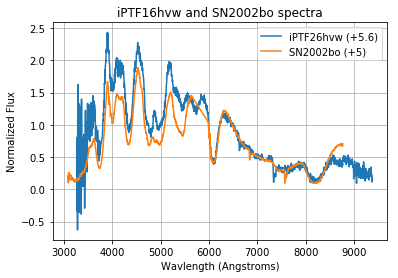

In [359]:
#Plot iPTF16hvw spectra
plt.figure()
plt.plot(Spec_16hvw3.spectra['Wavelength'], Spec_16hvw3.spectra['Flux'], label='iPTF26hvw (+5.6)')
plt.xlabel('Wavlength (Angstroms)')
plt.title('iPTF16hvw and SN2002bo spectra')
plt.ylabel('Normalized Flux')


#plot SN2002bo spectra 
plt.plot(Comp_2002bo1.spectra['Wavelength'], Comp_2002bo1.spectra['Flux'], label='SN2002bo (+5)')
plt.legend()
plt.savefig('../Images/2002bo_vs_16hvw/2002bo_comparison_spectra_5days')
plt.grid()

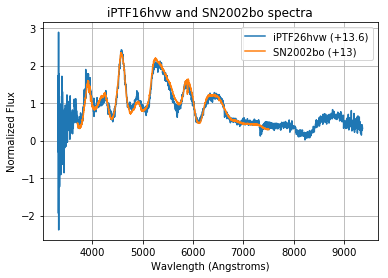

In [360]:
#Plot iPTF16hvw spectra
plt.figure()
plt.plot(Spec_16hvw4.spectra['Wavelength'], Spec_16hvw4.spectra['Flux'], label='iPTF26hvw (+13.6)')
plt.xlabel('Wavlength (Angstroms)')
plt.title('iPTF16hvw and SN2002bo spectra')
plt.ylabel('Normalized Flux')


#plot SN2002bo spectra 
plt.plot(Comp_2002bo2.spectra['Wavelength'], Comp_2002bo2.spectra['Flux'], label='SN2002bo (+13)')
plt.legend()
plt.savefig('../Images/2002bo_vs_16hvw/2002bo_comparison_spectra_13days')
plt.grid()

# iPTF16hvw Equivalent Width and Absorption Velocity Measurements

In [585]:
#Define a gaussian profile function to fit to the absorption line data
def Gaussian_profile(w, a, b, c, d, e):
    return a + b*w + c*np.exp(-((w - d)**2)/ e)

#Define a function to trim spectral data to capture absorption line
def Trim(spectra, start, stop):
    '''
    spectra - Spectral object 
    start - starting wavelength
    stop - stop wavelength
    '''
    return spectra.spectra.drop(spectra.spectra[(spectra.spectra.Wavelength <start) | (spectra.spectra.Wavelength > stop)].index)
   
def Calc_EW(Absorption, *popt):
    '''
    Absorption - trimmed Spectra of absorption line
    *popt - best fit parameters for gaussian fit
    '''
    cont_int = np.max(Absorption['Flux'])
    return integrate.quad(lambda x: 1 - ((Gaussian_profile(x, *popt)/ cont_int)), np.min(Absorption['Wavelength']), np.max(Absorption['Wavelength']))
    
def Calc_Centroid(Absorption ,*popt):
    '''
    Absorption - trimmed Spectra of absorption line
    *popt - best fit parameters for gaussian fit
    '''
    
    def Gauss(w , c, d, e):
        return c*np.exp(-((w - d)**2)/ e)
    
    minim = np.min(Absorption['Wavelength'])
    maxim = np.max(Absorption['Wavelength']) 
    return integrate.quad(lambda x:  x * Gauss(x, *popt[2:5]), minim, maxim)[0] / integrate.quad(lambda x:  Gauss(x, *popt[2:5]), minim, maxim)[0]

    

### Si II 6355 EW measurement

In [586]:
#Trim data of iPTF16hvw near Si II 6355 absorption line

#11/07/2016 spectra
SiII_1_6355 = Trim(Spec_16hvw1, 5750, 6250)

#11/28/16 spectra
SiII_3_6355 = Trim(Spec_16hvw3, 5900, 6300)

#12/06/16 spectra
SiII_4_6355 = Trim(Spec_16hvw4, 5900, 6350)


In [587]:
#Find the best fit parameters
popt1, pcov1 = curve_fit(Gaussian_profile, SiII_1_6355['Wavelength'], SiII_1_6355['Flux'], p0=[0, -2, 0, 5950, 1])
popt3, pcov3 = curve_fit(Gaussian_profile, SiII_3_6355['Wavelength'], SiII_3_6355['Flux'], p0=[0, -2, 0, 6100, 1])
popt4, cov4 = curve_fit(Gaussian_profile, SiII_4_6355['Wavelength'], SiII_4_6355['Flux'], p0=[0,-2,0,6100,1])




In [588]:
#Plot Fits
x1 = np.arange(5750, 6250, 1)
x3 = np.arange(5900, 6300, 1)
x4 = np.arange(5900, 6350,1)

y1 = Gaussian_profile(x1, *popt1)
y3 = Gaussian_profile(x3, *popt3)
y4 = Gaussian_profile(x4, *popt4)


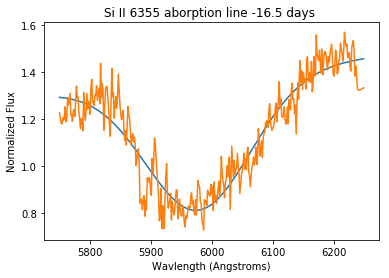

In [589]:
#Si II 6355 absorption line at -16.5 phase

plt.figure()
plt.plot(x1,y1)
plt.plot(SiII_1_6355['Wavelength'],SiII_1_6355['Flux'])
plt.xlabel('Wavlength (Angstroms)')
plt.ylabel('Normalized Flux')
plt.title("Si II 6355 aborption line -16.5 days ")

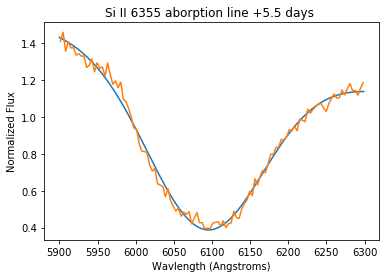

In [590]:
#Si II 6355 absorption line at +5.5 phase
plt.figure()
plt.plot(x3,y3)
plt.plot(SiII_3_6355['Wavelength'],SiII_3_6355['Flux'])
plt.xlabel('Wavlength (Angstroms)')
plt.ylabel('Normalized Flux')
plt.title("Si II 6355 aborption line +5.5 days ")

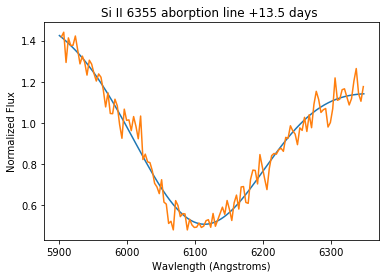

In [591]:
#Si II 6355 absorption line at +13.5 phase
plt.figure()
plt.plot(x4,y4)
plt.plot(SiII_4_6355['Wavelength'], SiII_4_6355['Flux'])
plt.xlabel('Wavlength (Angstroms)')
plt.ylabel('Normalized Flux')
plt.title("Si II 6355 aborption line +13.5 days ")




# <center> $W_{\lambda} = \int (\frac{F_{0}- F_{\lambda}}{F_{0}} )d\lambda = \int (1 - \frac{F_{\lambda}}{F_{0}} )d\lambda$ </centering>

In [592]:
#Calculate Equivalent Widths
EW_1 = Calc_EW(SiII_1_6355, *popt1)
EW_3 = Calc_EW(SiII_1_6355, *popt3)
EW_4 = Calc_EW(SiII_1_6355, *popt4)

In [593]:
print("EW of SiII 6355 -16.5 days:    "  + str(EW_1[0]) + " Angstroms")
print("EW of SiII 6355 5.5 days:     "  + str(EW_3[0]) + " Angstroms")
print("EW of SiII 6355 13.5 days:     "  + str(EW_4[0]) + " Angstroms")

EW of SiII 6355 -16.5 days:    136.02666805144327 Angstroms
EW of SiII 6355 5.5 days:     167.04592479619325 Angstroms
EW of SiII 6355 13.5 days:     163.54896318405983 Angstroms


In [594]:
#Calculate centroid of function

centroid_1 = Calc_Centroid(SiII_1_6355, *popt1)
centroid_3 = Calc_Centroid(SiII_3_6355, *popt3)
centroid_4 = Calc_Centroid(SiII_4_6355, *popt4)

In [595]:
print(centroid_1)
print(centroid_3)
print(centroid_4)

5978.386251405126
6091.422376107996
6108.5746035621505


In [596]:
#calculate absorption velocities using centroid as doppler shifted wavelength
print("Si II absorption velocity -16.5 days:   " + str(calc_abs_velc(SiII_restframe, centroid_1)) + " km/s")
print("Si II absorption velocity +5.5 days:   " + str(calc_abs_velc(SiII_restframe, centroid_3))+ " km/s")
print("Si II absorption velocity +13.5 days:   "  + str(calc_abs_velc(SiII_restframe, centroid_4))+ " km/s")

Si II absorption velocity -16.5 days:   17778.77648756289 km/s
Si II absorption velocity +5.5 days:   12442.68877538966 km/s
Si II absorption velocity +13.5 days:   11632.984882982666 km/s


### Si II 5972 EW measurement

In [559]:
#Trim data of iPTF16hvw near Si II 6355 absorption line

#11/07/2016 spectra
SiII_1_5972 = Trim(Spec_16hvw1, 5500, 5800)

#11/28/16 spectra
SiII_3_5972 = Trim(Spec_16hvw3, 5550, 5900)

#12/06/16 spectra
SiII_4_5972 = Trim(Spec_16hvw4, 5500, 5900)


In [560]:
#Find the best fit parameters
popt1_5972, pcov1_5972 = curve_fit(Gaussian_profile, SiII_1_5972['Wavelength'], SiII_1_5972['Flux'], p0=[0, -2, 0, 5600, 1])
popt3_5972, pcov3_5972 = curve_fit(Gaussian_profile, SiII_3_5972['Wavelength'], SiII_3_5972['Flux'], p0=[0, -2, 0, 5750, 1])
popt4_5972, pcov4_5972 = curve_fit(Gaussian_profile, SiII_4_5972['Wavelength'], SiII_4_5972['Flux'], p0=[0,-1,0,5700,3])

In [561]:
#Plot Fits
x1_5972 = np.arange(5500, 5900, 1)
x3_5972 = np.arange(5500, 5900, 1)
x4_5972 = np.arange(5500, 5900, 1)

y1_5972 = Gaussian_profile(x1_5972, *popt1_5972)
y3_5972 = Gaussian_profile(x3_5972, *popt3_5972)
y4_5972= Gaussian_profile(x4_5972, *popt4_5972)

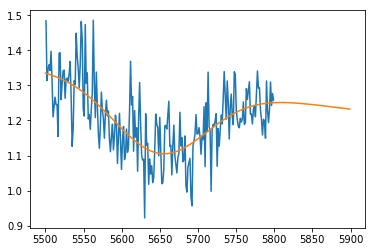

In [562]:
plt.plot(SiII_1_5972['Wavelength'], SiII_1_5972['Flux'])
plt.plot(x1_5972, y1_5972)

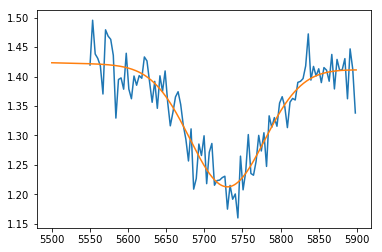

In [563]:
plt.plot(SiII_3_5972['Wavelength'], SiII_3_5972['Flux'])
plt.plot(x3_5972, y3_5972)

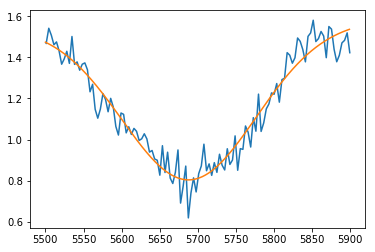

In [564]:
plt.plot(SiII_4_5972['Wavelength'], SiII_4_5972['Flux'])
plt.plot(x4_5972, y4_5972)

In [565]:
#Calculate Equivalent Widths
EW_1_5972 = Calc_EW(SiII_1_5972, *popt1_5972)
EW_3_5972 = Calc_EW(SiII_1_5972, *popt3_5972)
EW_4_5972 = Calc_EW(SiII_1_5972, *popt4_5972)

In [566]:
print("EW of SiII 5972 -16.5 days:    "  + str(EW_1_5972[0]) + " Angstroms")
print("EW of SiII 5972 -16.5 days:    "  + str(EW_3_5972[0]) + " Angstroms")
print("EW of SiII 5972 -16.5 days:    "  + str(EW_4_5972[0]) + " Angstroms")

EW of SiII 5972 -16.5 days:    56.64052318557707 Angstroms
EW of SiII 5972 -16.5 days:    28.880871362904355 Angstroms
EW of SiII 5972 -16.5 days:    84.12707163158832 Angstroms


# iPTF 16hvw & SN2002dj spectral sequences

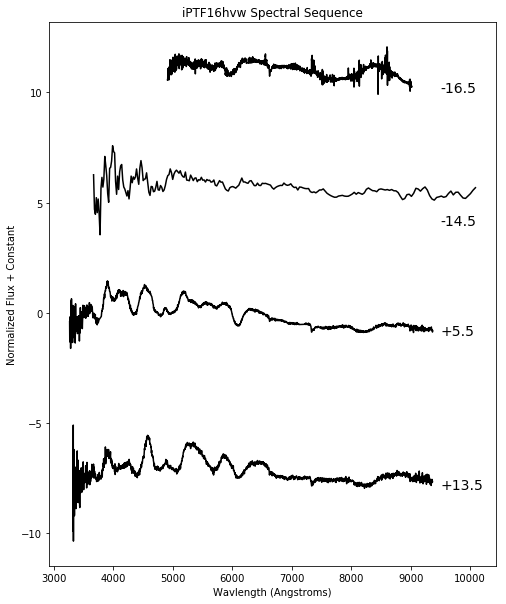

In [401]:
plt.figure(figsize=(8,10))
plt.title('iPTF16hvw Spectral Sequence')
plt.ylabel('Normalized Flux + Constant')
plt.xlabel('Wavlength (Angstroms)')

#iPTF16hvw

#plot phase = -16.5
plt.plot(Spec_16hvw1.spectra['Wavelength'], Spec_16hvw1.spectra['Flux'] + 10, color='black')
plt.text(9500, 10, "-16.5", fontsize=14)

#plot phase = 
plt.plot(Spec_16hvw2.spectra['Wavelength'], Spec_16hvw2.spectra['Flux'] + 5, color='black')
plt.text(9500, 4 , "-14.5", fontsize=14)

#plot phase = +5.5
plt.plot(Spec_16hvw3.spectra['Wavelength'], Spec_16hvw3.spectra['Flux'] -1, color='black')
plt.text(9500, -1, "+5.5", fontsize=14)

#plot phase = +13.5
plt.plot(Spec_16hvw4.spectra['Wavelength'], Spec_16hvw4.spectra['Flux'] - 8, color='black')
plt.text(9500, -8, "+13.5", fontsize=14)